In [ ]:
import torch

import matplotlib.pyplot as plt
import numpy as np

import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

import seaborn as sns
import torchmetrics.classification as tc

from functions.dl.convenience_functions import to_device, trialDir
from functions.dl.data_classes import SpectroDataset, CombinedSpectroDataset, SpectroDataLoader
from functions.dl.data_functions import splitDataset, load_data, load_model, train_model, getBestModel
from functions.dl.network_components import EarlyStopping, AudioToLogSpectrogram, AudioToMelSpectrogram, AudioToMFCCSpectrogram
from functions.processing.retrieval import loadPT

ray.init(ignore_reinit_error=True)
print("Ray is initialized!")

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-01-08 14:01:33,484	INFO worker.py:2007 -- Started a local Ray instance.


Ray is initialized!


f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [163]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [223]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-5, 1e-2),          # Learning rate between 1e-5 and 1e-2
    # "batch_size": tune.lograndint(8, 16), # for small batch testing
    "batch_size": tune.lograndint(32, 128),
    "nfft" : tune.choice([512, 1024, 2048, 4096, 8192]),
    "scale" : tune.uniform(0.5, 4),
    "power" : tune.uniform(0.5, 4),
    "patience" : tune.choice([2, 3, 5, 7, 9]),
    "EarlyDelta" : tune.uniform(0.0015, 0.1),
    "epochs" : tune.randint(15, max_epochs),
    "l1" : tune.loguniform(0.0005, 0.004),
    "l2" : tune.loguniform(0.00075, 0.003),
    "nmels" : tune.randint(64, 256),
    "nmfcc" : tune.randint(32, 128)
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [225]:
concurrent_trials = 2

# Load  dataset
# recording_path= "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_denoised"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_freq"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors"
# label_path="F:\\Persönliches\\Git\\BioOTon"
# ds = SpectroDataset(recording_path, label_path, device = 'cuda', denoised = True, filtered=False)

dawn_file = "F:/Persönliches/Git/BioOTon/points_single.parquet"
xeno_file = "F:/Persönliches/Git/BioOTon/xeno_points_single.parquet"
augmented_file = "F:/Persönliches/Git/BioOTon/augmented_points_single.parquet"

ds = CombinedSpectroDataset(dawn_file, xeno_file, augmented_file, device = device, denoised = True)

# Might need to adapt train_size according to how it is calculated in the split_dataset method
trainable_with_parameters = tune.with_parameters(
    train_model, dataset=ds, spectro_mode = "atmfs", train_size=500, val_size=100#train_size = int(np.floor(0.7 * len(ds))), val_size = int(np.floor(0.1 * len(ds)))# train_size=500, val_size=100
)

trainable_with_resources = tune.with_resources(
    trainable_with_parameters,
    resources={"cpu": 6/concurrent_trials, "gpu": 1/concurrent_trials, "accelerator_type:G":1/concurrent_trials}
)

optuna_search = OptunaSearch(
    metric=["loss", "accuracy"],
    mode=["min", "max"]
)

hyperopt_search = HyperOptSearch(
    metric="loss",
    mode="min",  # Minimize loss
    # points_to_evaluate # Use when some good hyperparameters are known as initial values
)

asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=max_epochs,
    grace_period=10,
    brackets=1,
)

# Pass the search algorithm to Ray Tune
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    # tune_config=tune.TuneConfig(search_alg=hyperopt_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=2),
    tune_config=tune.TuneConfig(search_alg=optuna_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=concurrent_trials,),
    run_config=tune.RunConfig(storage_path='D:/ProgramFiles/RayResults', name="results")
)
tuner.fit()

(pid=gcs_server) [2026-01-08 14:02:01,306 E 25320 29196] (gcs_server.exe) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2026-01-08 14:02:06,279 E 5204 19240] (raylet.exe) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(train_model pid=31000) Number of MFCC bins cannot be greater than number of Mel bins. Changing to a smaller number.
(train_model pid=31000) Getting index 60570, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27828591_audio_dn.pt
(train_model pid=31000) Getting index 60552, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27464142_audio_dn.pt
(train_model pid=31000) Getting index 60369, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27702083_audio_dn.pt
(train_model pid=31000) Getting index 60544, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\22454762_audio_dn.pt
(train_model pid=31000) Getting index 60613, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_629497_audio_dn.pt
(train_model pid=31000) Getting index 60323, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_28602927_audio_dn.pt
(train_model pid=31000) Getting index 60423, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27458555_audio_dn.pt
(train_model pid=31000) Getting index 60679, F:\

(train_model pid=13016) f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (199) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
(train_model pid=13016)   warnings.warn(


(train_model pid=30532) 
(train_model pid=30532) 65  :  7
(train_model pid=30532) Getting index 35, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27860362_audio_dn.pt [repeated 2056x across cluster]
(train_model pid=30532) [7,     8] loss: 2.290531 vloss: 2.249589
(train_model pid=13016) 
(train_model pid=30532) Model improved; checkpoint saved at loss 2.2496
(train_model pid=13016) 
(train_model pid=13016) 
(train_model pid=30532) Model improved; checkpoint saved at loss 2.1906
(train_model pid=30532) 65  :  7 [repeated 2x across cluster]
(train_model pid=30532) [8,     8] loss: 2.110359 vloss: 2.190600 [repeated 2x across cluster]
(train_model pid=13016) 
(train_model pid=30532) 
(train_model pid=30532) 
(train_model pid=30532) 
(train_model pid=30532) Getting index 60450, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22751444_audio_dn.pt [repeated 3359x across cluster]
(train_model pid=13016) 
(train_model pid=30532) Model improved; checkpoint saved at loss 2.2376


(train_model pid=14408) f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (210) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
(train_model pid=14408)   warnings.warn(


(train_model pid=13016) Model improved; checkpoint saved at loss 2.0776
(train_model pid=13016) 80  :  6
(train_model pid=13016) [15,     7] loss: 25.067009 vloss: 2.077629
(train_model pid=14408) Getting index 60557, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_22390917_audio_dn.pt [repeated 284x across cluster]
(train_model pid=14408) 79  :  6
(train_model pid=14408) [1,     7] loss: 42.997081 vloss: 3.559916
(train_model pid=14408) 79  :  6
(train_model pid=14408) [2,     7] loss: 42.803678 vloss: 3.591489
(train_model pid=14408) 79  :  6
(train_model pid=14408) [3,     7] loss: 42.614508 vloss: 3.506755
(train_model pid=14408) 79  :  6
(train_model pid=14408) [4,     7] loss: 42.428728 vloss: 3.456342
(train_model pid=14408) Getting index 60813, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27752942_audio_dn.pt [repeated 2403x across cluster]
(train_model pid=14408) 79  :  6
(train_model pid=14408) [5,     7] loss: 42.240376 vloss: 3.397574
(train_model pid=14408) 
(t

(train_model pid=15864) f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (206) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
(train_model pid=15864)   warnings.warn(


(train_model pid=14408) 
(train_model pid=14408) 79  :  6
(train_model pid=14408) [7,     7] loss: 41.869178 vloss: 3.301168
(train_model pid=14408) Model improved; checkpoint saved at loss 3.3012
(train_model pid=14408) Getting index 60572, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_27641657_audio_dn.pt [repeated 2127x across cluster]
(train_model pid=14408) 
(train_model pid=15864) 
(train_model pid=15864) 81  :  6 [repeated 3x across cluster]
(train_model pid=15864) [2,     7] loss: 41.469031 vloss: 3.258028 [repeated 3x across cluster]
(train_model pid=15864) 
(train_model pid=14408) 
(train_model pid=14408) 
(train_model pid=14408) 
(train_model pid=14408) Getting index 60343, F:\Persönliches\Git\BioOTon\AudioTensors_denoised\27649020_audio_dn.pt [repeated 3705x across cluster]
(train_model pid=15864) 
(train_model pid=15864) 
(train_model pid=14408) 79  :  6 [repeated 5x across cluster]
(train_model pid=14408) [11,     7] loss: 41.133204 vloss: 2.685205 [repeated 5x a

2026-01-08 14:09:10,677	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2026-01-08 14:09:10,736	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'D:/ProgramFiles/RayResults/results' in 0.0579s.
2026-01-08 14:09:11,388	INFO tune.py:1041 -- Total run time: 436.55 seconds (435.25 seconds for the tuning loop).
2026-01-08 14:09:11,389	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="D:/ProgramFiles/RayResults/results", trainable=...)


(train_model pid=30280) 95  :  5 [repeated 6x across cluster]
(train_model pid=29824) [3,     6] loss: 25.255936 vloss: 3.473802 [repeated 5x across cluster]
(train_model pid=30280) Getting index 23, F:\Persönliches\Git\BioOTon\augmented_data_denoised\wn_981994_audio_dn.pt [repeated 3408x across cluster]


ResultGrid<[
  Result(
    metrics={'loss': 2.3259284496307373, 'accuracy': 0.25},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_843764',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.6000008583068848, 'accuracy': 0.16},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_aed330',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.0555505752563477, 'accuracy': 0.29},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_48dc57',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.0558449427286782, 'accuracy': 0.31},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_0d7246',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.9361789226531982, 'accuracy': 0.2},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_51cda6',
    filesystem='local',
    checkpoint=None
  ),
  Result(
   

In [ ]:
model, df = getBestModel(return_df=True)

In [ ]:
# Plot loss vs learning rate
sns.scatterplot(x="config/lr", y="loss", data=df)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

In [ ]:
%tensorboard --logdir runs/single_points/

In [ ]:
train_indices, test_indices, val_indices  = splitDataset(ds)
test_dataloader = SpectroDataLoader(ds, batch_size, samples= test_indices[:150], device = "cuda")

Getting F:\Persönliches\Git\BioOTon\AudioTensors\23857077_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22294964_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\26223311_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22294960_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22329529_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\26574358_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22303197_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\23848329_audio.pt
Best Hyperparameters: {'lr': 0.00018217292899600795, 'batch_size': 2, 'nfft': 4096, 'scale': 3.3285967358612116, 'power': 1.7831184599879397, 'patience': 9, 'EarlyDelta': 0.0549733297167698, 'epochs': 17, 'l1': 0.003237281614796639, 'l2': 0.0015806433029207302}
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22398674_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22398677_audio.pt
Getting F:\Persönliches\Git\BioOTon\AudioTensors\22370546_audio.pt
G

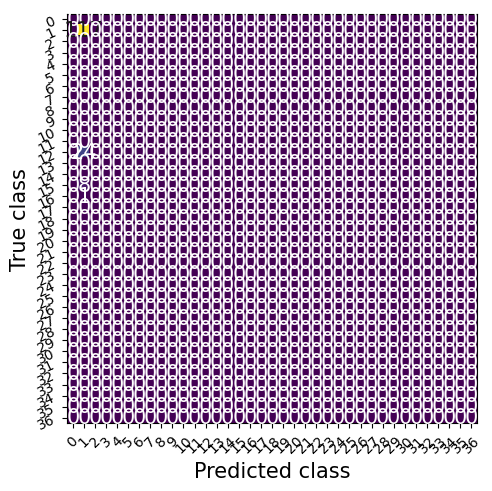

Recall of the custom cnn: tensor(0.2500, device='cuda:0')
F1-score of the custom cnn: tensor(0.2191, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.2500, device='cuda:0')


In [ ]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        model = getBestModel()
        inp = model(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())